# **Emotion Classification**

*Natural Language Processing - Final Project*

Group Member:


1.   2301879274 - Armendo Chandra
2.   2301869853 - Stephen Jasper
3.   2301869784 - Yesika

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim.downloader as api
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
from matplotlib.colors import LinearSegmentedColormap

# Fungsi visualize_emotions untuk menampilkan jumlah data dari setiap dataset beserta detail klasifikasi emotion

In [2]:
def visualize_emotions(df, title):
  # menghitung jumlah label pada kolom Emotions
  num_labels = df['Emotions'].value_counts()

  # jumlah kategori yang unik
  x_barchart = range(df['Emotions'].nunique())
  # membuat list dari jumlah label
  y_barchart = list(num_labels.values)

  # membuat list dari label masing-masing emotion
  x_barchart_labels = [str(emotions_to_labels[emotion]) + ' - ' + emotion for emotion in list(num_labels.index)]

  # membuat bar chart
  plt.figure(figsize = (5, 4))
  plt.bar(x_barchart, y_barchart, color='pink')

  # menambahkan jumlah elemen dari setiap kategori emotion menjadi suatu text 
  for index, data in enumerate(y_barchart):
    plt.text(x = index, y = data+max(y_barchart)/100, s = '{}'.format(data), fontdict = dict(fontsize=10), ha = 'center')
  
  plt.xticks(x_barchart, x_barchart_labels, rotation=40)
  plt.title('Number of emotions in {} dataset'.format(title))
  plt.tight_layout()
  print('There are {} records in the dataset.\n'.format(len(df.index)))
  plt.show()

# Fungsi text_preprocess untuk melakukan pembersihan data seperti menghilangkan karakter yang tidak membentuk kata, menghilangkan stop words, serta melakukan tokenisasi text

In [3]:
def text_preprocess(text, stop_words=False):
  # menghilangkan kata yang non-words
  text = re.sub(r'\W+', ' ', text).lower()

  # melakukan tokenisasi text
  tokens = word_tokenize(text)

  if stop_words:
    # menghapus stop_words
    tokens = [token for token in tokens if token not in STOPWORDS]
  return tokens

# Fungsi create_weight_matrix untuk membuat weight matrix yang akan digunakan untuk membuat model

In [4]:
def create_weight_matrix(model, second_model=False):
  vector_size = model.get_vector('like').shape[0]
  w_matrix = np.zeros((DICT_SIZE, vector_size))
  skipped_words = []

  for word, index in tokenizer.word_index.items():
    if index < DICT_SIZE:
      if word in model: 
        w_matrix[index] = model.get_vector(word)
      else:
        if second_model:
          if word in second_model:
            w_matrix[index] = second_model.get_vector(word)
          else:
            skipped_words.append(word)
        else:
          skipped_words.append(word)
 
  print(f'{len(skipped_words)} words were skipped. Some of them:')
  print(skipped_words[:50])
  return w_matrix

# Fungsi show_result untuk menampilkan hasil akurasi dan error

In [5]:
def show_result(result):
    accuracy = result.history['accuracy']
    val_accuracy = result.history['val_accuracy']
    loss = result.history['loss']
    val_loss = result.history['val_loss']
    
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, label='Training acc', color='red')
    plt.plot(x, val_accuracy, label='Validation acc', color='blue')
    plt.grid(True)
    plt.legend()
    plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss', color='red')
    plt.plot(x, val_loss, label='Validation loss', color='blue')
    plt.grid(True)
    plt.legend()
    plt.title('Loss')

# Fungsi show_confusion_matrix untuk menampilkan korelasi antar-feature



In [6]:
def show_confusion_matrix(matrix):
  plt.figure(figsize=(7, 5))
  sns.heatmap(matrix, annot=True, xticklabels=emotions_to_labels.keys(), yticklabels=emotions_to_labels.keys())
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

# Fungsi predict untuk melakukan prediksi terhadap data yang ingin diuji

In [7]:
def predict(texts):
  texts_prepr = [text_preprocess(t) for t in texts]
  sequences = tokenizer.texts_to_sequences(texts_prepr)
  pad = pad_sequences(sequences, maxlen=MAX_LEN)

  predictions = model.predict(pad)
  labels = np.argmax(predictions, axis=1)
  
  for i, lbl in enumerate(labels):
    print(f'\'{texts[i]}\' show {labels_to_emotions[lbl]} emotion')

# Main

Mengimport dataset train.txt, test.txt, dan val.txt

In [8]:
train = pd.read_csv('train.txt', sep=';', header= None, names= ['Sentences','Emotions'], encoding= 'utf-8')
test = pd.read_csv('test.txt', sep =';', header= None, names= ['Sentences','Emotions'], encoding= 'utf-8')
validation = pd.read_csv('val.txt', sep=';', header= None, names= ['Sentences','Emotions'], encoding= 'utf-8')

Membuat label encoder untuk klasifikasi emosi dan membuat kolom baru untuk label

In [9]:
# emotions_to_labels = {'anger': 0, 'love': 1, 'fear': 2, 'joy': 3, 'sadness': 4,'surprise': 5}
emotions_to_labels = {'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4,'surprise': 5}
labels_to_emotions = {j:i for i,j in emotions_to_labels.items()}

train['Labels'] = train['Emotions'].replace(emotions_to_labels)
test['Labels'] = test['Emotions'].replace(emotions_to_labels)
validation['Labels'] = validation['Emotions'].replace(emotions_to_labels)

Melakukan visualisasi data menggunakan fungsi visualize_emotions

There are 16000 records in the dataset.



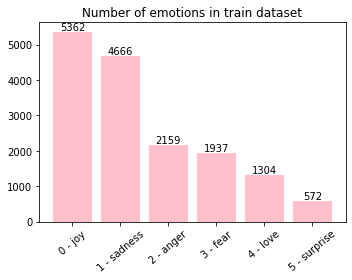

There are 2000 records in the dataset.



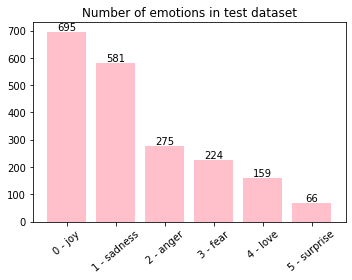

There are 2000 records in the dataset.



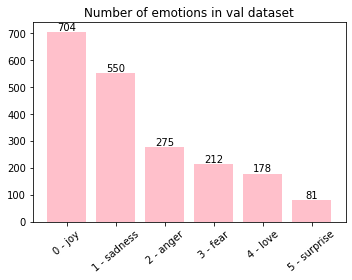

In [10]:
visualize_emotions(train, 'train')
visualize_emotions(test, 'test')
visualize_emotions(validation, 'val')

Mendownload 'punkt', 'stopwords', dan set of stop-words

In [11]:
nltk.download('punkt')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Melakukan preprocessing data untuk training, testing, dan validation

In [12]:
x_train = [text_preprocess(t, stop_words=True) for t in train['Sentences']]
y_train = train['Labels'].values

x_test = [text_preprocess(t, stop_words=True) for t in test['Sentences']]
y_test = test['Labels'].values

x_validation = [text_preprocess(t, stop_words=True) for t in validation['Sentences']]
y_validation = validation['Labels'].values

Berikut ini adalah data sebelum dan sesudah preprocessing

In [13]:
print('Before: ')
print(train.head())
print('\nAfter:')
for line_and_label in list(zip(x_train[:5], y_train[:5])):
  print(line_and_label)

Before: 
                                           Sentences Emotions  Labels
0                            i didnt feel humiliated  sadness       1
1  i can go from feeling so hopeless to so damned...  sadness       1
2   im grabbing a minute to post i feel greedy wrong    anger       2
3  i am ever feeling nostalgic about the fireplac...     love       4
4                               i am feeling grouchy    anger       2

After:
(['didnt', 'feel', 'humiliated'], 1)
(['go', 'feeling', 'hopeless', 'damned', 'hopeful', 'around', 'someone', 'cares', 'awake'], 1)
(['im', 'grabbing', 'minute', 'post', 'feel', 'greedy', 'wrong'], 2)
(['ever', 'feeling', 'nostalgic', 'fireplace', 'know', 'still', 'property'], 4)
(['feeling', 'grouchy'], 2)


Memuat pre-trained model

In [14]:
model_wiki = api.load('fasttext-wiki-news-subwords-300')

Memuat word2vec model

In [15]:
model_w2v = Word2Vec(x_train + x_test + x_validation, size=300, min_count = 2).wv  

Membuat corpus yang berisi kata yang sering digunakan

In [16]:
DICT_SIZE = 15000
tokenizer = Tokenizer(num_words=DICT_SIZE)
total = x_train + x_train + x_validation
tokenizer.fit_on_texts(total)

Mencari panjang maksimum dari kalimat yang ada didalam dataset

In [17]:
x_train_max_len = max([len(i) for i in x_train])
x_test_max_len = max([len(i) for i in x_test])
x_validation_max_len = max([len(i) for i in x_validation])
MAX_LEN = max(x_train_max_len, x_test_max_len, x_validation_max_len)

Mereplace kata dengan indexnya dan mengganti ukuran vector menjadi panjang maksimum dan pad index

In [18]:
X_train = tokenizer.texts_to_sequences(x_train)
X_train_pad = pad_sequences(X_train, maxlen=MAX_LEN)

X_test = tokenizer.texts_to_sequences(x_test)
X_test_pad = pad_sequences(X_test, maxlen=MAX_LEN)

X_val = tokenizer.texts_to_sequences(x_validation)
X_val_pad = pad_sequences(X_val, maxlen=MAX_LEN)

Membuat weight matrix menggunakan fungsi create_weight_matrix

In [19]:
weight_matrix = create_weight_matrix(model_wiki, model_w2v)

991 words were skipped. Some of them:
['jacynthe', 'rupaul', 'kayle', 'gerling', 'mxm', 'dannika', 'hyperchondria', 'manitz', 'educationg', 'gosman', 'montauk', 'bummin', 'wheeeeee', 'underwears', 'olivias', 'bandhu', 'uplifter', 'suicidalness', 'dykey', 'provokingbeauty', 'bodypump', 'honkerblonked', 'clermont', 'instructables', 'janne', 'suominen', 'kamiki', 'nozomi', 'nonchan', 'beaubronz', 'docrat', 'allthingsbucks', 'irresponcible', 'scruncher', 'utf', 'isprivate', 'ismobile', 'mobileclass', 'isprivateblog', 'languagedirection', 'feedlinks', 'lorena', 'handss', 'nervs', 'mommyhood', 'nowwwwww', 'whitleys', 'forelorn', 'baachan', 'covingtons']


Menginisialisasi early stopping

In [20]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

Membuat model sequential

In [21]:
model = Sequential()
model.add(Embedding(input_dim = DICT_SIZE, output_dim = weight_matrix.shape[1], input_length = X_train_pad.shape[1], weights=[weight_matrix], trainable=False)) 
model.add(Bidirectional(LSTM(128, return_sequences=True))) 
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dense(6, activation = 'softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

Melakukn training data sebanyak 10 epochs menggunakan model sequential yang telah dibuat

In [22]:
result = model.fit(X_train_pad, y_train, validation_data = (X_val_pad, y_validation), epochs = 10, batch_size = 8, callbacks = early_stop)

Epoch 1/10
2000/2000 [==============================] - 49s 20ms/step - loss: 0.9058 - accuracy: 0.6687 - val_loss: 0.4270 - val_accuracy: 0.8455
Epoch 2/10
2000/2000 [==============================] - 39s 19ms/step - loss: 0.2532 - accuracy: 0.9057 - val_loss: 0.1780 - val_accuracy: 0.9235
Epoch 3/10
2000/2000 [==============================] - 39s 19ms/step - loss: 0.1614 - accuracy: 0.9308 - val_loss: 0.1541 - val_accuracy: 0.9320
Epoch 4/10
2000/2000 [==============================] - 38s 19ms/step - loss: 0.1384 - accuracy: 0.9354 - val_loss: 0.1201 - val_accuracy: 0.9405
Epoch 5/10
2000/2000 [==============================] - 38s 19ms/step - loss: 0.1262 - accuracy: 0.9364 - val_loss: 0.1392 - val_accuracy: 0.9260
Epoch 6/10
2000/2000 [==============================] - 39s 19ms/step - loss: 0.1146 - accuracy: 0.9394 - val_loss: 0.1279 - val_accuracy: 0.9305
Epoch 7/10
2000/2000 [==============================] - 39s 20ms/step - loss: 0.1065 - accuracy: 0.9428 - val_loss: 0.1130 -

Menampilkan hasil akurasi dan error dari proses training menggunakan fungsi show_result

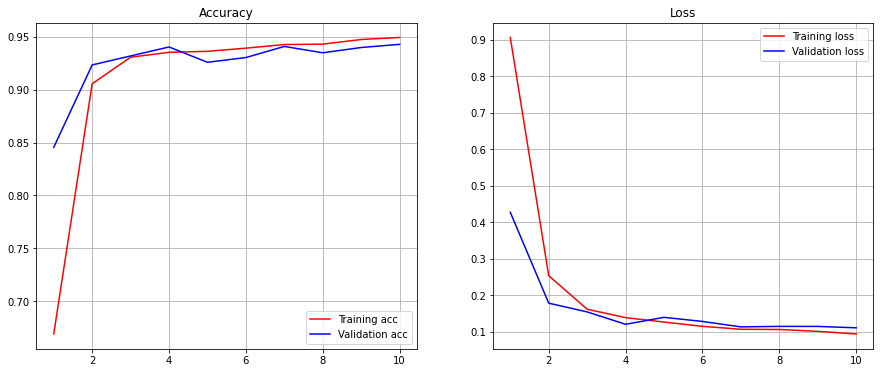

In [23]:
show_result(result)

Melakukan evaluasi data menggunakan model sequential yang telah dibuat 

In [24]:
model.evaluate(X_test_pad, y_test) 

63/63 [==============================] - 3s 13ms/step - loss: 0.1459 - accuracy: 0.9235


[0.14591927826404572, 0.9235000014305115]

Melakukan prediksi pada testing data dan menampilkan classification report

In [25]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       695
           1       0.95      0.98      0.97       581
           2       0.98      0.88      0.93       275
           3       0.85      0.89      0.87       224
           4       0.83      0.81      0.82       159
           5       0.79      0.64      0.71        66

    accuracy                           0.92      2000
   macro avg       0.89      0.86      0.87      2000
weighted avg       0.92      0.92      0.92      2000



Menampilkan confusion matrix menggunakan fungsi show_confusion_matrix

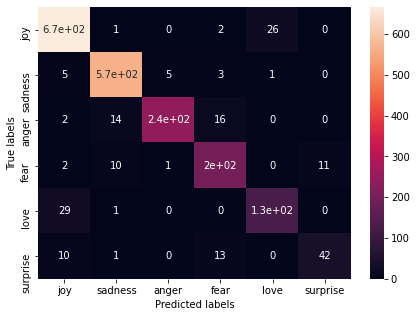

In [26]:
matrix = metrics.confusion_matrix(y_test, y_pred)
show_confusion_matrix(matrix)

Melakukan uji coba untuk model sequential yang telah dibuat

In [37]:
test_texts = ['i mad at you because you left me suddenly', 'i feel his supportive arms', 'i am scared of snake', 'after all of the sadness, i am happy to see you smile', 'i just lost my phone', 'she feels shocked and wondering what is happening now']
predict(test_texts)

'i mad at you because you left me suddenly' show anger emotion
'i feel his supportive arms' show love emotion
'i am scared of snake' show fear emotion
'after all of the sadness, i am happy to see you smile' show joy emotion
'i just lost my phone' show sadness emotion
'she feels shocked and wondering what is happening now' show surprise emotion
